# Assignment 2 - Stitching

_Tiffany Wang - 260684152_ 

In [39]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [40]:
hill1 = Image.open('./stitching_images/1Hill.JPG')
hill2 = Image.open('./stitching_images/2Hill.JPG')
hill3 = Image.open('./stitching_images/3Hill.JPG')

hill1 = np.array(hill1)
hill2 = np.array(hill2)
hill3 = np.array(hill3)

h1, w1, _ = hill1.shape
h2, w2, _ = hill2.shape
h3, w3, _ = hill3.shape

In [41]:
def Blending(A, B, depth=6):
    # generate Gaussian pyramid for A
    GA, GB = A.copy(), B.copy()
    gpA, gpB = [GA], [GB]
    for i in range(depth):
        GA = cv2.pyrDown(GA)
        gpA.append(GA)

        GB = cv2.pyrDown(GB)
        gpB.append(GB)

    # generate Laplacian Pyramid for A and B
    lpA, lpB = [gpA[depth-1]], [gpB[depth-1]]
    for i in range(depth-1,0,-1):
        hA, wA, _ = gpA[i-1].shape
        L = cv2.subtract(gpA[i-1],cv2.pyrUp(gpA[i], dstsize=(wA, hA)))
        lpA.append(L)

        hB, wB, _ = gpB[i-1].shape
        L = cv2.subtract(gpB[i-1], cv2.pyrUp(gpB[i], dstsize=(wB, hB)))
        lpB.append(L)

    # Now add left and right halves of images in each level
    LS = []
    for la,lb in zip(lpA,lpB):
        _, col, _ = la.shape
        ls = np.hstack((la, lb))
        LS.append(ls)

    # now reconstruct
    rs = LS[0]
    for i in range(1,depth):
        h, w, _ = LS[i].shape
        rs = cv2.pyrUp(rs, dstsize=(w, h))
        rs = cv2.add(rs, LS[i])
        
    return rs.astype(np.uint8)

#### 1. Compute SIFT keypoints and corresponding descriptors for images 1Hill and 2Hill.


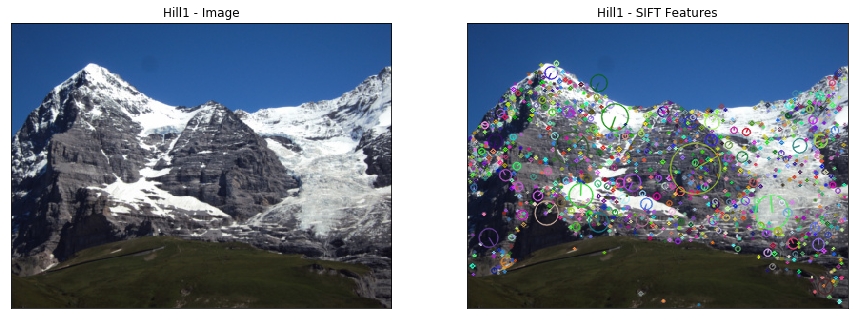

descriptors size: (1254, 128)


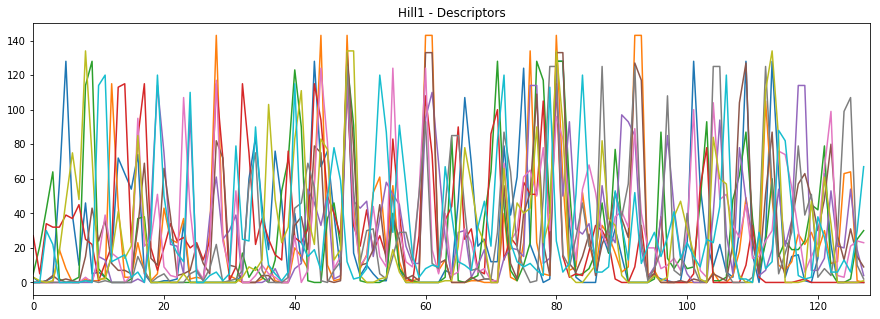

In [42]:
###############################################################
# Find SIFT keypoints and corresponding descriptors for 1Hill #
###############################################################

# copy of image 
hill1 = np.array(hill1)
hill1_c = hill1.copy()

# create a SIFT object
sift = cv2.xfeatures2d.SIFT_create()

# detect SIFT features, with no masks
kp1, des1 = sift.detectAndCompute(hill1, None)

# draw the keypoints
cv2.drawKeypoints(hill1, kp1, hill1_c, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


# display
plt.figure(figsize=(15,7))
plt.subplot(121), plt.imshow(hill1)
plt.title("Hill1 - Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(hill1_c)
plt.title("Hill1 - SIFT Features"), plt.xticks([]), plt.yticks([])
plt.show()

# num of SIFT descriptors
print('descriptors size: '+ str(des1.shape))

# plot a couple of 1x128 SIFT descriptors
num = 10
plt.figure(figsize=(15, 5))
plt.title('Hill1 - Descriptors')
for i in range(num):
    plt.plot(des1[i])
    plt.xlim([0,128]) 
plt.show()

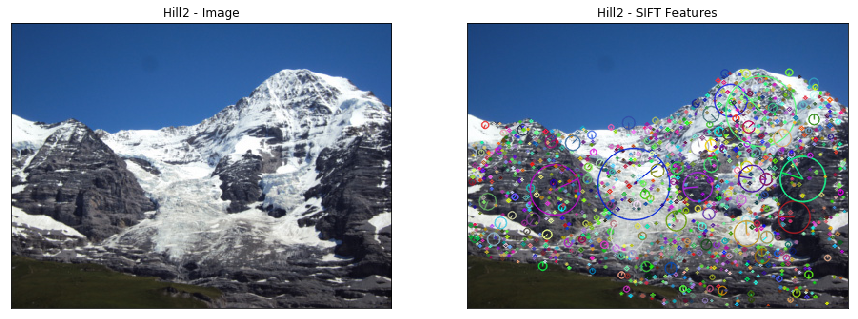

descriptors size: (1472, 128)


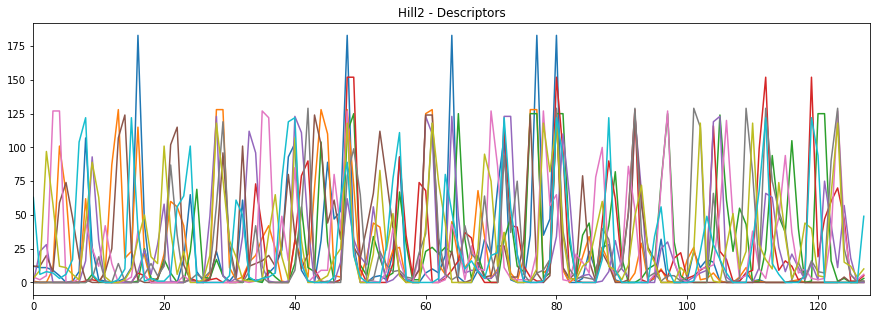

In [43]:
###############################################################
# Find SIFT keypoints and corresponding descriptors for 2Hill #
###############################################################

# copy of image 
hill2 = np.array(hill2)
hill2_c = hill2.copy()

# create a SIFT object
sift = cv2.xfeatures2d.SIFT_create()

# detect SIFT features, with no masks
kp2, des2 = sift.detectAndCompute(hill2, None)

# draw the keypoints
cv2.drawKeypoints(hill2, kp2, hill2_c, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


# display
plt.figure(figsize=(15,7))
plt.subplot(121), plt.imshow(hill2)
plt.title("Hill2 - Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(hill2_c)
plt.title("Hill2 - SIFT Features"), plt.xticks([]), plt.yticks([])
plt.show()


# num of SIFT descriptors
print('descriptors size: '+ str(des2.shape))

# plot a couple of 1x128 SIFT descriptors
num = 10
plt.figure(figsize=(15, 5))
plt.title('Hill2 - Descriptors')
for i in range(num):
    plt.plot(des2[i])
    plt.xlim([0,128]) 
plt.show()

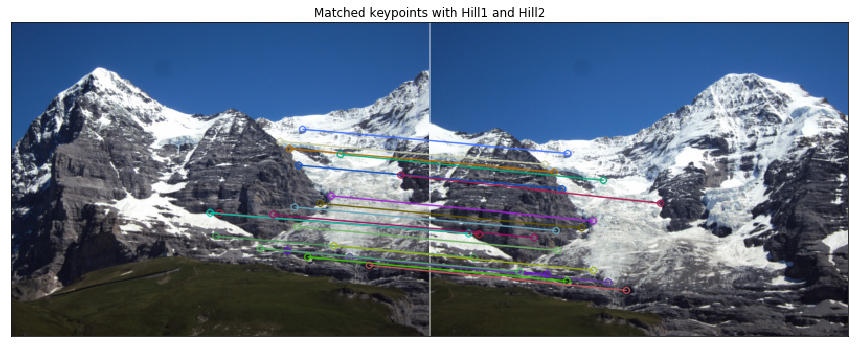

In [44]:
# create BFMatcher object
bf = cv2.BFMatcher()

# Match descriptors.
matches = bf.match(des1, des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 20 matches.
nb = 20
match_res = cv2.drawMatches(hill1,kp1, hill2, kp2, matches[:nb], hill1, flags=2)

plt.figure(figsize=(15,15))
plt.imshow(match_res)
plt.title("Matched keypoints with Hill1 and Hill2"), plt.xticks([]), plt.yticks([])
plt.show()

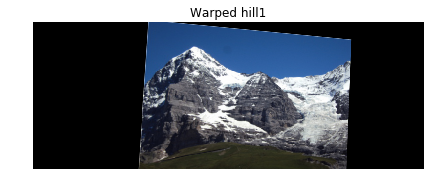

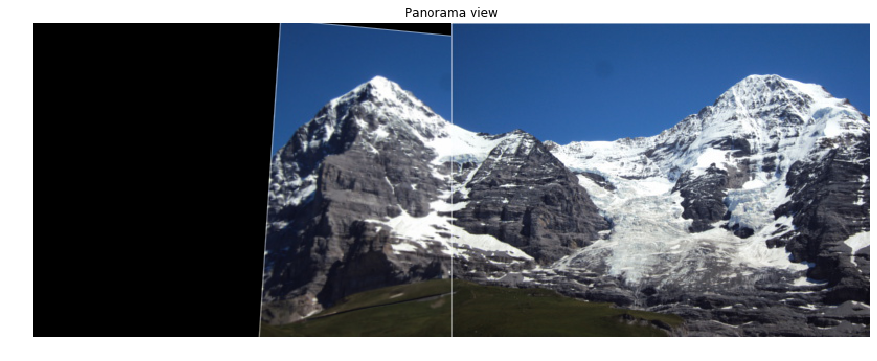

In [45]:
GoodMatches = []
for i, m in enumerate(matches):
    GoodMatches.append((m.trainIdx, m.queryIdx))
    
# GoodMatches = GoodMatches[:-1]
pts_r = np.float32([kp2[i].pt for (i, __) in GoodMatches])
pts_l = np.float32([kp1[i].pt for (__, i) in GoodMatches])

# We shift all the points in the right image over as they are on smaller canvas
for i in range(len(pts_r)):
    pts_r[i][0] += hill2.shape[1]

M, _ = cv2.findHomography(pts_l, pts_r, cv2.RANSAC, 5)

# Use homography
warped = cv2.warpPerspective(hill1, M, (w1 + w2, h2))

plt.figure(figsize=(7,7))
plt.imshow(warped)
plt.title("Warped hill1"), plt.axis('off')
plt.show()

glued = warped.copy()
glued[:, w2:,:] = hill2
plt.figure(figsize=(15,15))
plt.imshow(glued)
plt.title("Panorama view"), plt.axis('off')
plt.show()

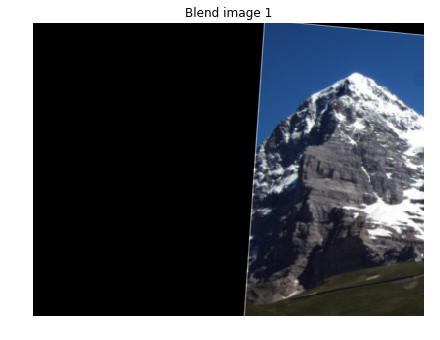

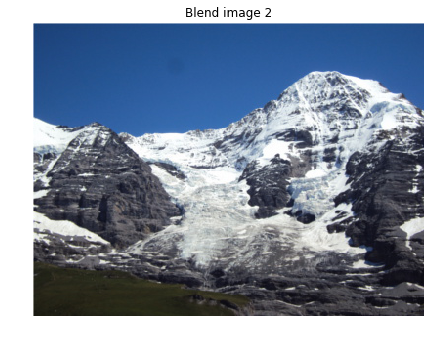

In [46]:
img1 = warped[:, :w1]
img2 = hill2

plt.figure(figsize=(7,7))
plt.imshow(img1)
plt.title("Blend image 1"), plt.axis('off')
plt.show()

plt.figure(figsize=(7,7))
plt.imshow(img2)
plt.title("Blend image 2"), plt.axis('off')
plt.show()

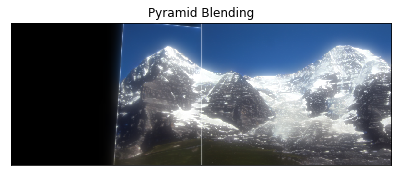

In [47]:
hill12 = Blending(warped[:,:w1], hill2, 5)

# display results
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(hill12)
plt.title('Pyramid Blending'), plt.xticks([]), plt.yticks([])
plt.show()

In [48]:
h12, w12, _ = hill12.shape

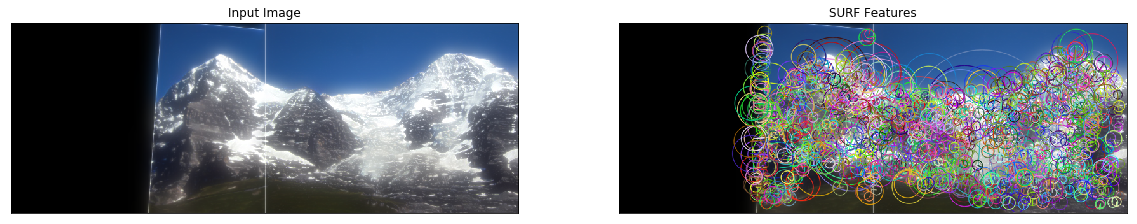

Num keypoints: 1266
descriptors size: (1266, 64)


In [49]:
#########################
# Find SIFT keypoints and corresponding descriptors for 12Hill #
#########################

# copy image
hill12_c = hill12.copy()
# convert to grayscale
hill12_grey = cv2.cvtColor(hill12, cv2.COLOR_BGR2GRAY)

# create SURF object
surf = cv2.xfeatures2d.SURF_create()

# detect SURF features
kp12, des12 = surf.detectAndCompute(hill12_grey, None)

# draw keypoints
cv2.drawKeypoints(hill12, kp12, hill12_c, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# display images
plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(hill12)
plt.title("Input Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(hill12_c)
plt.title("SURF Features"), plt.xticks([]), plt.yticks([])
plt.show()

# number of SURF keypoints
print("Num keypoints: " + str(len(kp12)))

# num of SIFT descriptors
print('descriptors size: '+ str(des12.shape))


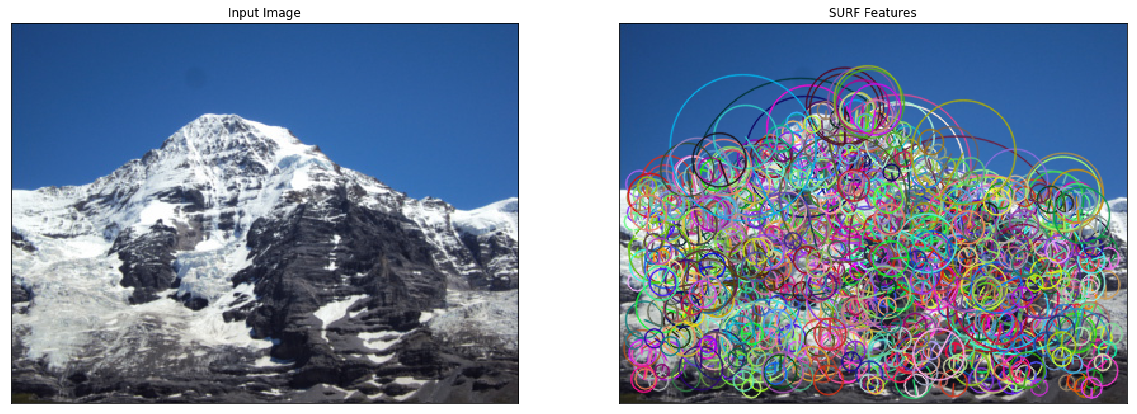

Num keypoints: 875
descriptors size: (875, 64)


In [50]:
#########################
# Find SIFT keypoints and corresponding descriptors for 3Hill #
#########################

# copy image
hill3_c = hill3.copy()
# convert to grayscale
hill3_grey = cv2.cvtColor(hill3, cv2.COLOR_BGR2GRAY)

# create SURF object
surf = cv2.xfeatures2d.SURF_create()

# detect SURF features
kp3, des3 = surf.detectAndCompute(hill3_grey, None)

# draw keypoints
cv2.drawKeypoints(hill3, kp3, hill3_c, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# display images
plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(hill3)
plt.title("Input Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(hill3_c)
plt.title("SURF Features"), plt.xticks([]), plt.yticks([])
plt.show()

# number of SURF keypoints
print("Num keypoints: " + str(len(kp3)))

# num of SIFT descriptors
print('descriptors size: '+ str(des3.shape))


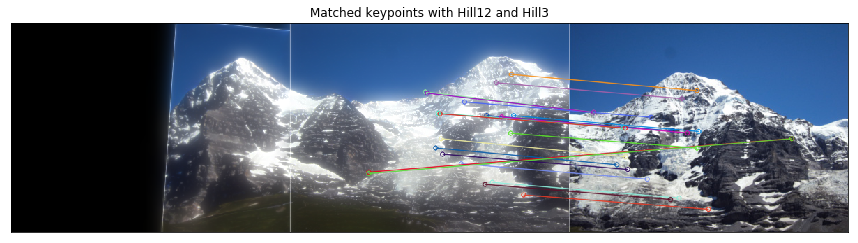

In [52]:
# create BFMatcher object
bf = cv2.BFMatcher()
# Match descriptors.
matches_123 = bf.match(des12, des3)
# Sort them in the order of their distance.
matches_123 = sorted(matches_123, key = lambda x:x.distance)

# Draw first 20 matches.
nb = 20
match_res = cv2.drawMatches(hill12, kp12, hill3, kp3, matches_123[:nb], hill12, flags=2)

plt.figure(figsize=(15,15))
plt.imshow(match_res)
plt.title("Matched keypoints with Hill12 and Hill3"), plt.xticks([]), plt.yticks([])
plt.show()



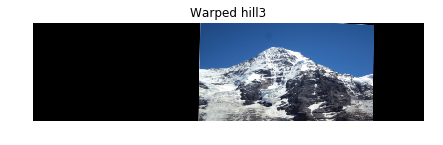

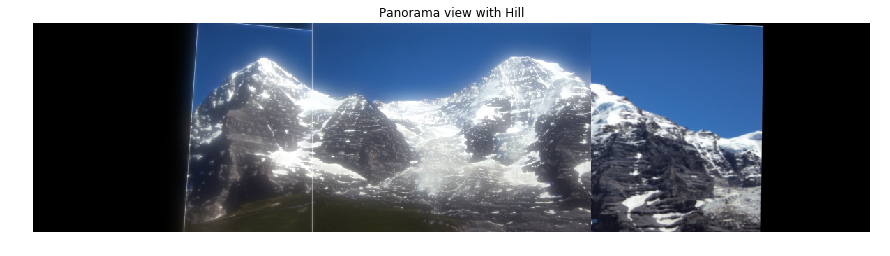

In [88]:
# Match descriptors.
matches_312 = bf.match(des3, des12)
# Sort them in the order of their distance.
matches_312 = sorted(matches_312, key = lambda x:x.distance)

good_312 = []
for _, m in enumerate(matches_312):
    good_312.append((m.trainIdx, m.queryIdx))

# GoodMatches = GoodMatches[:-1]
pts_l = np.float32([kp12[i].pt for (i, __) in good_312])
pts_r = np.float32([kp3[i].pt for (__, i) in good_312])

# We shift all the points in the right image over as they are on smaller canvas
for i in range(len(pts_r)):
    pts_r[i][0] += w12 + w3

M, _ = cv2.findHomography(pts_l, pts_r, cv2.RANSAC, 10)

# Use homography
warped3 = cv2.warpPerspective(hill3, M, (w1 + w2 + w3, h2))

plt.figure(figsize=(7,7))
plt.imshow(warped3)
plt.title("Warped hill3"), plt.axis('off')
plt.show()

glued = warped3.copy()
glued[:, :w12,:] = hill12
plt.figure(figsize=(15,15))
plt.imshow(glued)
plt.title("Panorama view with Hill"), plt.axis('off')
plt.show()

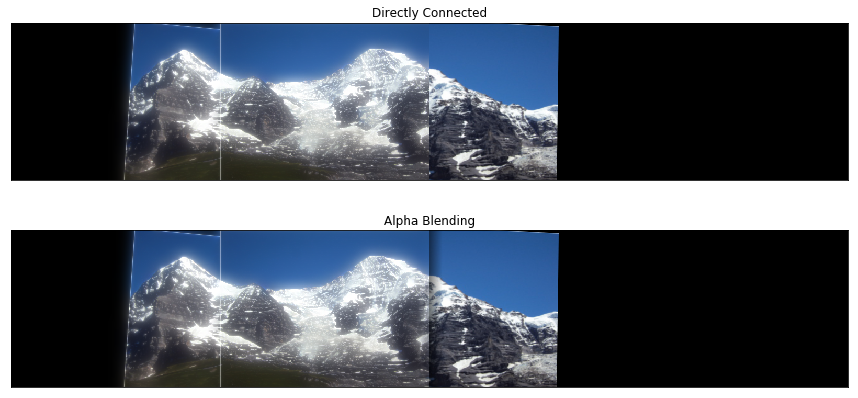

In [98]:
##################
# IMAGE BLENDING #
##################

# read images
img1 = np.zeros((h12, w12 * 2, 3)).astype(np.uint8)
img1[:,:w12,:] = hill12


img2 = np.zeros(img1.shape).astype(np.uint8)
img2[:,:w3+w12,:] = warped3
# img2 = warped3

# image with direct connecting each half
real = np.hstack((img1[:,:w12,:], img2[:,w12:,:])).astype(np.uint8)

""" ALPHA BLENDING """
def Ramp(i_width, r_width, r_index, start, end):
    """
    Create alpha blending function
    :param i_width: img width
    :param r_width: ramp width
    :param r_index: center ramp index
    :param start: starting ramp value
    :param end: ending ramp value
    :return:
    """
    a = np.zeros((i_width))
    step = (end - start) / (r_width-1)
    idx = round(r_index - (r_width / 2))  # left side starting index of alpha ramp
    for i in range(r_width):
        a[idx] = start + step*i
        idx += 1
    a[idx:] = 1
    return a

# alpha blending ramp
ramp_size = 50  # alpha blending ramp size
alpha = Ramp(img1.shape[1], ramp_size, round(img1.shape[1]/2), 0, 1)

# Now blend
I_blend = (1-alpha.reshape(1,-1,1)) * img1 + alpha.reshape(1,-1,1) * img2
I_blend = np.uint8(I_blend)  # convert back to uint8

# display images
plt.figure(figsize=(15,7))
plt.subplot(211), plt.imshow(real)
plt.title("Directly Connected"), plt.xticks([]), plt.yticks([])
plt.subplot(212), plt.imshow(I_blend)
plt.title("Alpha Blending"), plt.xticks([]), plt.yticks([])
plt.show()